# Bigram Demo

### From Basic to Attention-Based

#### Imports

In [15]:
import time
from typing import Tuple, List, Optional
import torch
from torch import nn
from utils.data_utils import read_in_data, tensor_to_string
from utils.basic_tokeniser import create_simple_encoder_decoder
from my_models.bigram import (
    BigramModel,
    BigramModelWithAttention,
    BigramModelWithAandPE,
    BigramModelWithAandPEandLN,
    BigramModelWithAandPEandLNandFFN,
    BigramModelWithAandPEandLNandFFNandDO,
    BigramWithTransformerBlocks,
)
import matplotlib.pyplot as plt

In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [17]:
# Set Random Seed for Reproducibility
torch.manual_seed(6345789)  # Set the random seed for reproducibility
# Wilson Pickett - 634-5789 https://www.youtube.com/watch?v=TSGuaVAufV0
pass

#### Set the Hyperparameters

In [18]:
# Set Hyperparameters
batch_size = 32  # This is the size of the batch of data that will be processed at once
block_size = 64  # This is the size of the context window
max_iters = 1000  # How many iterations to train for
eval_every = max_iters // 10  # How often to evaluate the model
embedding_dim = 256  # The size of the embedding dimension
lr = 3e-4
eval_iters = 100  # How many iterations to evaluate for
dropout_prob = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cpu


#### Load the Data

In [19]:
data_folder = "data/madlibs/"

# First we read in the data 'data/asimov/asimov_data_1000.txt'
char_dict, data = read_in_data(data_folder + "dummy_data_1000_lines.txt")

# Create the encoder and decoder dictionaries and the encode and decode functions
encoder_dict, decoder_dict, encode, decode = create_simple_encoder_decoder(char_dict)

with open(data_folder + "decoded_train_data.txt", "r") as f:
    train_data = f.read()
with open(data_folder + "decoded_val_data.txt", "r") as f:
    val_data = f.read()
with open(data_folder + "decoded_test_data.txt", "r") as f:
    test_data = f.read()

# Load the data into torch tensor
train_data = torch.tensor(encode(train_data), dtype=torch.long)
val_data = torch.tensor(encode(val_data), dtype=torch.long)
test_data = torch.tensor(encode(test_data), dtype=torch.long)

Corpus has 24 unique letter(s), 0 unique numbers(s) and 3 unique punctuation(s)
Corpus has 27 unique characters.


Recall the data format:

**det adj noun verb prep det adj noun**

In [20]:
print(f"Sample of the data:\n\n{tensor_to_string(train_data[:214],decode)}")

Sample of the data:

a purple book writes to its green tree.
the large cat runs at your small dog.
that tall book runs under its small computer.
your gray house jumps below my dainty tree.
this robotic chair speaks to your black book.


In [21]:
# Utility functions to get batches of data and estimate the loss


def get_batch(split: str) -> Tuple[torch.Tensor, torch.Tensor]:
    """Get a batch of data from the train, validation or test set."""

    if split == "train":
        data = train_data
    elif split == "val":
        data = val_data
    elif split == "test":
        data = test_data
    else:
        raise ValueError(f"Unknown split: '{split}'")
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)  # Transfer the data to the GPU if we are using it
    return x, y


@torch.no_grad()
def estimate_loss(model_):
    """Evaluate the model on the validation set.
    Returns:
    """
    model_.eval()  # Put the model in evaluation mode
    out = {}
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for i in range(eval_iters):
            x, y = get_batch(split)
            _, loss = model_(idx=x, target=y)
            losses[i] = loss.item()
        out[split] = losses.mean().item()
    model_.train()
    return out

In [22]:
# Bigram Training Loop, Evaluation and Generation
def bigram_train_and_generate(
    model: nn.Module,
    max_iters: int,
    eval_every: int = 1000,
    plots: Optional[bool] = True,
    verbose: Optional[bool] = False,
    num_chars: Optional[int] = 100,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model for a number of iterations and evaluate it every `eval_every` iterations.
    Returns:
        model: The trained model.
        train_losses: The training losses for each evaluation step.
        val_losses: The validation losses for each evaluation step.
        num_chars: The number of characters to generate.
    """

    model.print_param_count()  # Print the number of parameters in the model
    Optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # Training loop
    print(f"Training {type(model).__name__} for {max_iters} iterations...")
    # Measure the time taken for the training
    start_time = time.time()
    last_time = start_time
    for i in range(max_iters):
        if i % eval_every == 0:
            losses = estimate_loss(model)
            # Print Step, train loss and validation loss
            if verbose:
                print(
                    f'At Iteration: {i}, Train loss: {losses["train"]}, Val loss: {losses["val"]}'
                )
                # Print the time taken for the last eval_every iteration(s)
                print(
                    f"Time taken for last {eval_every} iterations: {(time.time() - last_time):.2f} seconds"
                )
                last_time = time.time()
            train_losses.append(losses["train"])
            val_losses.append(losses["val"])

        # Get a batch of data
        xb, yb = get_batch("train")

        # Zero the gradients
        Optimiser.zero_grad()

        # Get the embeddings and the loss (Forward pass)
        embeds, loss = model(idx=xb, target=yb)

        # Backpropagate the loss (Backward pass)
        loss.backward()

        # Take a step with the optimiser
        Optimiser.step()

    total_time = int(time.time() - start_time)
    hours = total_time // 3600
    minutes = (total_time % 3600) // 60
    seconds = total_time % 60

    if plots:
        # Create x axis values tensor
        x = torch.arange(1, max_iters + 1, eval_every)
        # Plot the losses
        plt.plot(x, train_losses, label="train")
        plt.plot(x, val_losses, label="val")
        plt.title(f"Losses for the {type(model).__name__} model over {max_iters} steps")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    # Print the final losses and Generate some text
    print(f"Model: {type(model).__name__}")
    print(
        f"Time taken for training: {hours} hours, {minutes} minutes, {seconds} seconds"
    )
    print(f"Train Loss: {train_losses[-1]:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}")

    # Generate some text
    print(f"Generating for Model: {type(model).__name__}")
    chars = decode(
        model.generate(idx=torch.zeros((1, 1), dtype=torch.long), length=num_chars)[
            0
        ].tolist()
    )
    # Join the characters together and then print the string
    print("".join(chars))

    return model, train_losses, val_losses

### Bigram Model

First start with a Vanilla Bigram model. No understanding of position or attention. Just a simple bigram model.

BigramModel has 729 parameters.
Training BigramModel for 1000 iterations...


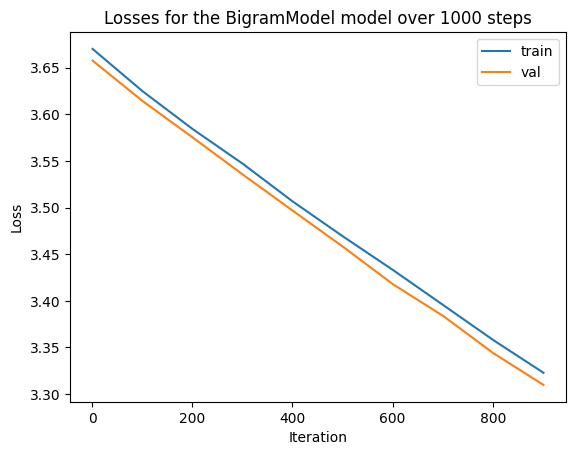

Model: BigramModel
Time taken for training: 0 hours, 0 minutes, 3 seconds
Train Loss: 3.3229
Val Loss: 3.3098
Generating for Model: BigramModel

ftttrbdob itquamdeddvk
hmbm
rwb r. r.n
k
pwmksy lg
ks.melfowfabq eddmkedalamdmdd ru
hphrdcpabs
rjplg


In [23]:
# Initialise the model
model1 = BigramModel(len(encoder_dict), embedding_dim=len(encoder_dict))
# Train the model
_ = bigram_train_and_generate(
    model1,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=100,
)

Not seeing a lot of improvement in the loss. So add in attention and pass in the whole block of text.

### Attention

Attention is a mechanism that allows the model to focus on certain parts of the input sequence when decoding. It is a mechanism that allows the model to learn which parts of the input sequence are important. The attention mechanism is a matrix multiplication between the input sequence and the output sequence. The output sequence is the sequence of hidden states from the encoder. The input sequence is the sequence of hidden states from the decoder. The output of the matrix multiplication is a matrix of attention weights. The attention weights are then multiplied by the input sequence to get the attention output. The attention output is then concatenated with the output of the decoder and passed through a linear layer to get the final output.

BigramModelWithAttention has 277,019 parameters.
Training BigramModelWithAttention for 1000 iterations...


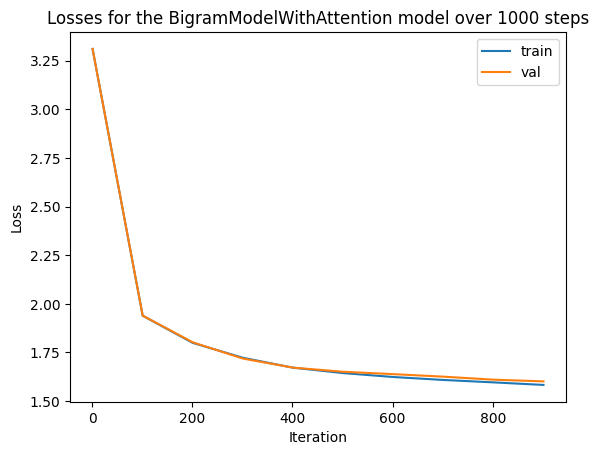

Model: BigramModelWithAttention
Time taken for training: 0 hours, 1 minutes, 7 seconds
Train Loss: 1.5833
Val Loss: 1.6015
Generating for Model: BigramModelWithAttention

the eaks t thoreallous abelllllow t t ps choue t atreirerove airge thabl se.
toksmphe aismataks ts b


In [24]:
### Bigram with Attention
model2 = BigramModelWithAttention(
    len(encoder_dict), embedding_dim=embedding_dim, block_size=block_size
)
_ = bigram_train_and_generate(
    model2,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=100,
)

### Transformer Architecture
<figure>
  <img src="data/images/transformer_image.png" style="width:10%">
      <figcaption>
        Image from a transformer taken from <a href="https://arxiv.org/abs/1706.03762">here</a>.
      </figcaption>
</figure>

T

I have already stepped through the Attention mechanism. So I will start with the Positional Encoding and incrementally add the other components until we have the final model.

#### Adding Positional Encodings

Positional encodings are used to encode the position of each word in the input sequence. They are used to improve the performance of the model. The positional encodings are added to the input sequence before it is passed through the encoder.

BigramModelWithAandPE has 293,403 parameters.
Training BigramModelWithAandPE for 1000 iterations...


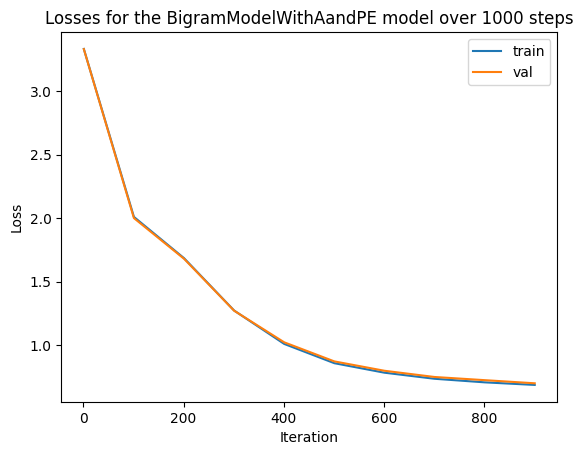

Model: BigramModelWithAandPE
Time taken for training: 0 hours, 1 minutes, 7 seconds
Train Loss: 0.6863
Val Loss: 0.6991
Generating for Model: BigramModelWithAandPE

hourple purple ats quick computer reads in above talks to its to its blue writes under thin fain you


In [25]:
# Initialise the model
model3 = BigramModelWithAandPE(
    len(encoder_dict), embedding_dim=embedding_dim, block_size=block_size
)
# Train the model
_ = bigram_train_and_generate(
    model3,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=100,
)

Immediately, we see a big improvement in the loss. Combined with attention, positional information helps the model to learn the structure of the input sequence. There are still a few incoherent words being generated, so we add LayerNormalization.

#### Adding Layer Normalisation

Layer Normalisation is used to improve performance.

BigramModelWithAandPEandLN has 293,915 parameters.
Training BigramModelWithAandPEandLN for 1000 iterations...


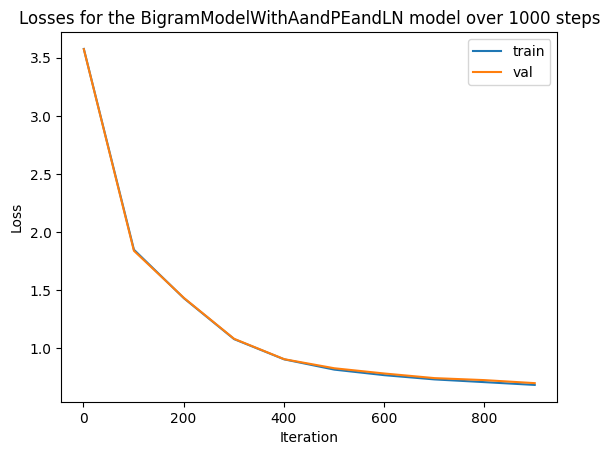

Model: BigramModelWithAandPEandLN
Time taken for training: 0 hours, 1 minutes, 4 seconds
Train Loss: 0.6819
Val Loss: 0.6972
Generating for Model: BigramModelWithAandPEandLN

my their dainty book.
a quiits on a smart table.
a thin tyell car.
this unde car dainty hour thin o 


In [26]:
# Initialise the model
model4 = BigramModelWithAandPEandLN(
    len(encoder_dict), embedding_dim=embedding_dim, block_size=block_size
)
# Train the model
_ = bigram_train_and_generate(
    model4,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=100,
)

We are basically there at this point. The loss is still decreasing but the model is generating coherent words. So we add a dropout layer to prevent overfitting.
#### Adding Feed Forward Network

Feed Forward Networks are used to transform the input vector into a new vector. They are composed of two linear layers with a ReLU activation function in between. They add non-linearity to the model and should help it to learn more complex patterns.

BigramModelWithAandPEandLNandFFN has 819,483 parameters.
Training BigramModelWithAandPEandLNandFFN for 1000 iterations...


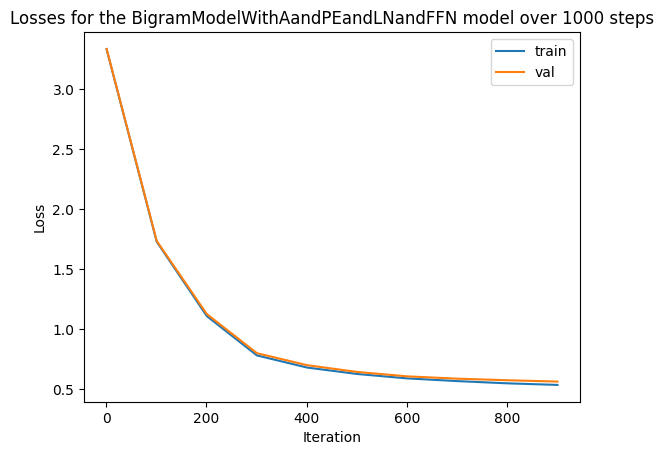

Model: BigramModelWithAandPEandLNandFFN
Time taken for training: 0 hours, 2 minutes, 0 seconds
Train Loss: 0.5357
Val Loss: 0.5635
Generating for Model: BigramModelWithAandPEandLNandFFN

that dainty car ehinks at house.
my quick truns below a black dog.
this red my robotic house writes 


In [27]:
# Initialise the model
model5 = BigramModelWithAandPEandLNandFFN(
    len(encoder_dict), embedding_dim=embedding_dim, block_size=block_size
)
# Train the model
_ = bigram_train_and_generate(
    model5,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=100,
)

#### Adding Dropout

Dropout is a regularization technique that is used to prevent the model from overfitting the training data. It is used to improve the performance of the model.

BigramModelWithAandPEandLNandFFNandDO has 819,483 parameters.
Training BigramModelWithAandPEandLNandFFNandDO for 1000 iterations...


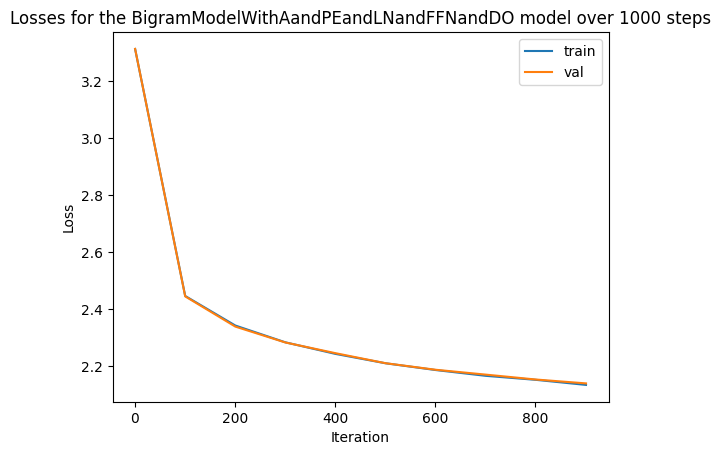

Model: BigramModelWithAandPEandLNandFFNandDO
Time taken for training: 0 hours, 1 minutes, 43 seconds
Train Loss: 2.1346
Val Loss: 2.1400
Generating for Model: BigramModelWithAandPEandLNandFFNandDO

at vee s p yatk hruror apbesees w rtlhoungee ok trat ire sic ge y blkthe wrablheeenovo ga br phit yo


In [28]:
# Initialise the model
model6 = BigramModelWithAandPEandLNandFFNandDO(
    len(encoder_dict),
    embedding_dim=embedding_dim,
    block_size=block_size,
    dropout_prob=dropout_prob,
)
# Train the model
_ = bigram_train_and_generate(
    model6,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=100,
)

Interestingly, the loss is not decreasing and the model is generating incoherent words. We try for more iterations below

BigramModelWithAandPEandLNandFFNandDO has 819,483 parameters.
Training BigramModelWithAandPEandLNandFFNandDO for 9000 iterations...


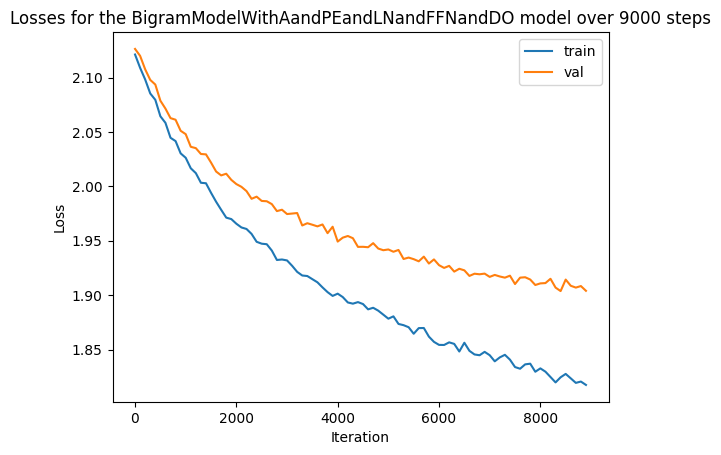

Model: BigramModelWithAandPEandLNandFFNandDO
Time taken for training: 0 hours, 16 minutes, 6 seconds
Train Loss: 1.8176
Val Loss: 1.9040
Generating for Model: BigramModelWithAandPEandLNandFFNandDO

your thinedlaueite ricar trlaick.hedbonhis k y tr d rour wa ok lounn ctoweetrgeai eall athisharalal 


In [29]:
# Train model6 for more iterations
_ = bigram_train_and_generate(
    model6,
    max_iters=9000,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=100,
)

This is still incoherent even though the loss is decreasing. We can try to train for more iterations, but we will stop here.

### Putting it all together

We have now built the different components of the transformer architecture save for the residual connections. We can now put them all together into a block - allowing us to and create multiple blocks to form the encoder and decoder setup. I will investigate the impact of the blocks on the performance of the model starting with 1 block and increasing the number of blocks.

**Note:** The model below is essentially the same as model6 above but with the transformer block (hence with the residual connections).

BigramWithTransformerBlocks has 1,609,243 parameters.
Training BigramWithTransformerBlocks for 1000 iterations...


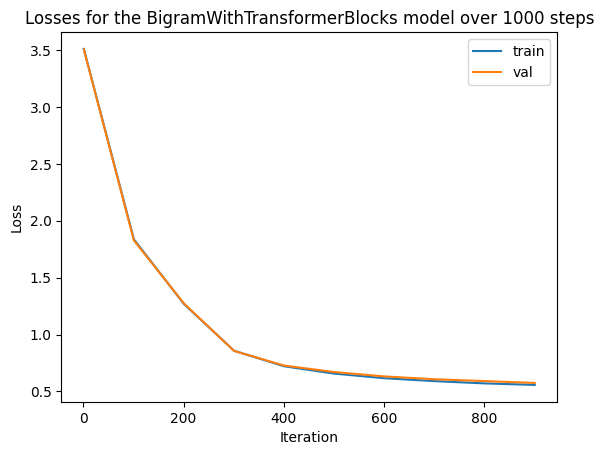

Model: BigramWithTransformerBlocks
Time taken for training: 0 hours, 2 minutes, 35 seconds
Train Loss: 0.5566
Val Loss: 0.5740
Generating for Model: BigramWithTransformerBlocks

that large reads behind this large walks on a orange computer.
a this fat purple house.
your robotic phone book reads behind book.
that large tree sleeps over a dainty phone.
my orange dog their fat t


In [30]:
# Instantiate the model with 1 block
model7 = BigramWithTransformerBlocks(
    len(encoder_dict),
    embedding_dim=embedding_dim,
    block_size=block_size,
    num_blocks=1,
    dropout_prob=dropout_prob,
)

# Train the model
_ = bigram_train_and_generate(
    model7,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=200,
)

BigramWithTransformerBlocks has 2,399,003 parameters.
Training BigramWithTransformerBlocks for 1000 iterations...


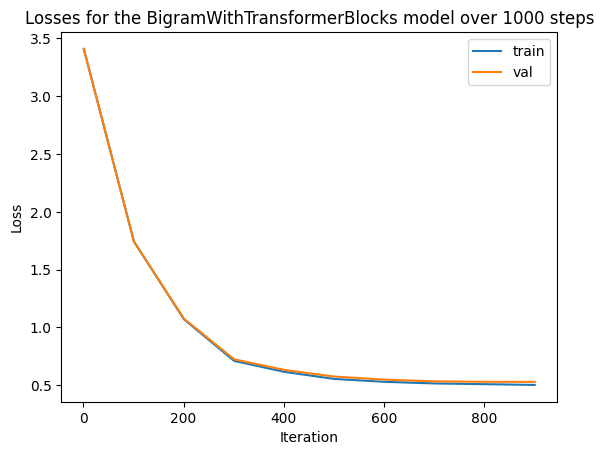

Model: BigramWithTransformerBlocks
Time taken for training: 0 hours, 4 minutes, 26 seconds
Train Loss: 0.5032
Val Loss: 0.5295
Generating for Model: BigramWithTransformerBlocks

a white cat speaks over that tall book.
this dainty computer writes behind oour yellow computer.
their large treen book speaks to iran your red car reads behind the yellow house.
a gray chair speaks i


In [31]:
# Instantiate the model with 2 blocks
model8 = BigramWithTransformerBlocks(
    len(encoder_dict),
    embedding_dim=embedding_dim,
    block_size=block_size,
    num_blocks=2,
    dropout_prob=dropout_prob,
)

# Train the model
_ = bigram_train_and_generate(
    model8,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=200,
)

BigramWithTransformerBlocks has 3,188,763 parameters.
Training BigramWithTransformerBlocks for 1000 iterations...


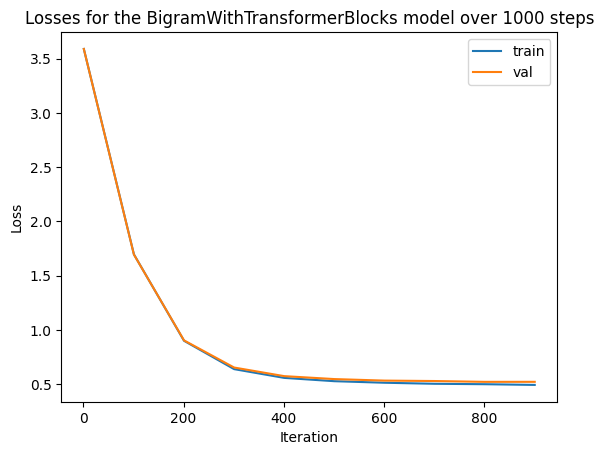

Model: BigramWithTransformerBlocks
Time taken for training: 0 hours, 7 minutes, 8 seconds
Train Loss: 0.4949
Val Loss: 0.5235
Generating for Model: BigramWithTransformerBlocks

this gray dog.
your brown phone writes beside this black dog.
your orange phone walks under that dainty book.
a yellow chair walks beside book.
this yellow computer eats beside a smart house.
a our ye


In [32]:
# Instantiate the model with 3 blocks
model9 = BigramWithTransformerBlocks(
    len(encoder_dict),
    embedding_dim=embedding_dim,
    block_size=block_size,
    num_blocks=3,
    dropout_prob=dropout_prob,
)

# Train the model
_ = bigram_train_and_generate(
    model9,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=200,
)

BigramWithTransformerBlocks has 3,978,523 parameters.
Training BigramWithTransformerBlocks for 1000 iterations...


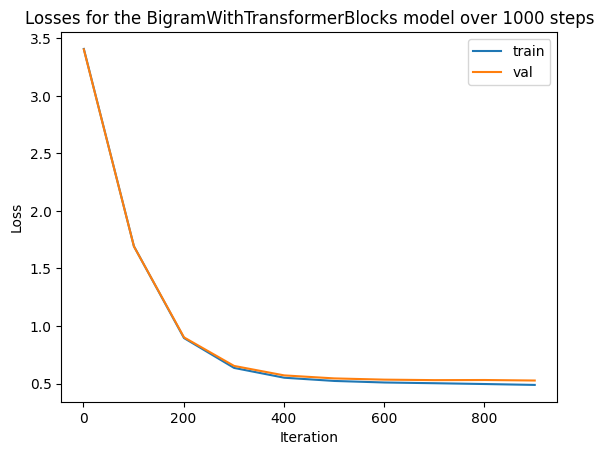

Model: BigramWithTransformerBlocks
Time taken for training: 0 hours, 8 minutes, 22 seconds
Train Loss: 0.4879
Val Loss: 0.5261
Generating for Model: BigramWithTransformerBlocks

myour gray car reads on your dainty table.
your red dog ren to the red.
a green book reads under a brown computer.
that yellow dog jumps in our brown computer.
an orange house jumps beside that short 


In [33]:
# Finally, instantiate the model with 4 blocks
model10 = BigramWithTransformerBlocks(
    len(encoder_dict),
    embedding_dim=embedding_dim,
    block_size=block_size,
    num_blocks=4,
    dropout_prob=dropout_prob,
)
# Train the model
_ = bigram_train_and_generate(
    model10,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=200,
)

### The Great Gatsby

We have now built a transformer model that can generate coherent words. We will now use it to generate text from a different dataset. We will use the same preprocessing steps as above.
The dataset is relatively simple with no long term dependencies. So we now look to learn over and generate something with a more complex dataset.

Andrej used the Shakespeare dataset in his blog post. I will use a slightly different dataset, The Great Gatsby by F Scott Fitzgerald. The dataset is available [here](https://www.gutenberg.org/cache/epub/64317/pg64317.txt). I have already downloaded the dataset and saved it in the data folder. I will use the same preprocessing steps as above.

In [34]:
import os
from utils.dummy_file_generators import save_data_as_txt

# First we read in the data 'data/asimov/asimov_data_1000.txt'
data_folder = "data/gatsby/"
char_dict, data = read_in_data(data_folder + "great_gatsby.txt")

# Create the encoder and decoder dictionaries and the encode and decode functions
encoder_dict, _, encode, decode = create_simple_encoder_decoder(char_dict)

if not os.path.exists(data_folder + "decoded_train_data.txt"):
    # Load the data into torch tensor
    data = torch.tensor(encode(data), dtype=torch.long)
    # Apply the decode function to the data when converted to a list
    decoded_data = decode(data.tolist())

    train_data = data[: int(len(data) * 0.7)]
    val_data = data[int(len(data) * 0.7) : int(len(data) * 0.9)]
    test_data = data[int(len(data) * 0.9) :]

    # Create the train data if the saved file doesn't already exist

    # Create an 70, 20, 10 train, validation, test split
    train_data_str = tensor_to_string(train_data, decode)
    val_data_str = tensor_to_string(val_data, decode)
    test_data_str = tensor_to_string(test_data, decode)

    # Save the data as a text file
    save_data_as_txt(train_data_str, data_folder + "decoded_train_data.txt")
    save_data_as_txt(val_data_str, data_folder + "decoded_val_data.txt")
    save_data_as_txt(test_data_str, data_folder + "decoded_test_data.txt")

else:
    # Read in the data
    with open(data_folder + "decoded_train_data.txt", "r") as f:
        train_data = f.read()
    with open(data_folder + "decoded_val_data.txt", "r") as f:
        val_data = f.read()
    with open(data_folder + "decoded_test_data.txt", "r") as f:
        test_data = f.read()

    # Load the data into torch tensor
    train_data = torch.tensor(encode(train_data), dtype=torch.long)
    val_data = torch.tensor(encode(val_data), dtype=torch.long)
    test_data = torch.tensor(encode(test_data), dtype=torch.long)

Corpus has 30 unique letter(s), 10 unique numbers(s) and 23 unique punctuation(s)
Corpus has 88 unique characters.


In [35]:
# Restate the utility functions

# Utility functions to get batches of data and estimate the loss


def get_batch(split: str) -> Tuple[torch.Tensor, torch.Tensor]:
    """Get a batch of data from the train, validation or test set."""

    if split == "train":
        data = train_data
    elif split == "val":
        data = val_data
    elif split == "test":
        data = test_data
    else:
        raise ValueError(f"Unknown split: '{split}'")
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)  # Transfer the data to the GPU if we are using it
    return x, y


@torch.no_grad()
def estimate_loss(model_):
    """Evaluate the model on the validation set.
    Returns:
    """
    model_.eval()  # Put the model in evaluation mode
    out = {}
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for i in range(eval_iters):
            x, y = get_batch(split)
            _, loss = model_(idx=x, target=y)
            losses[i] = loss.item()
        out[split] = losses.mean().item()
    model_.train()
    return out

In [36]:
# Restate the hyperparameters
# Set Hyperparameters
batch_size = 32  # This is the size of the batch of data that will be processed at once
block_size = 64  # This is the size of the context window
max_iters = 5000  # How many iterations to train for
eval_every = max_iters // 10  # How often to evaluate the model
embedding_dim = 256  # The size of the embedding dimension
lr = 3e-4
eval_iters = 100  # How many iterations to evaluate for
dropout_prob = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cpu


BigramWithTransformerBlocks has 1,627,711 parameters.
Training BigramWithTransformerBlocks for 5000 iterations...


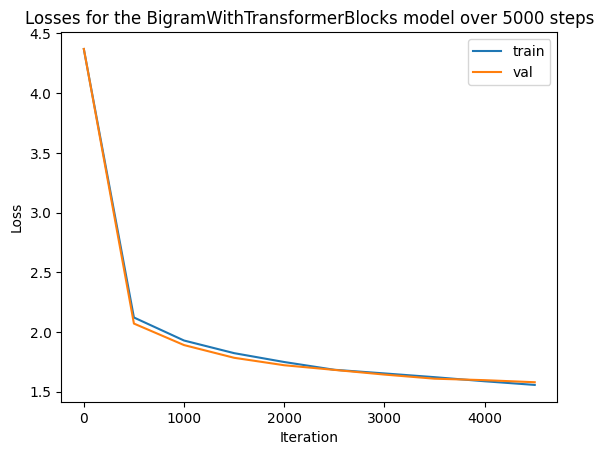

Model: BigramWithTransformerBlocks
Time taken for training: 0 hours, 8 minutes, 43 seconds
Train Loss: 1.5569
Val Loss: 1.5794
Generating for Model: BigramWithTransformerBlocks

book blan awayded ceive an oto word with daces of the ant
owno one
wind that
yose the
unfienince the somewhed sew over to good dried very car thems time and with was owled by munted this from in viita


In [37]:
# Initialise the model
model11 = BigramWithTransformerBlocks(
    len(encoder_dict),
    embedding_dim=embedding_dim,
    block_size=block_size,
    num_blocks=1,
    dropout_prob=dropout_prob,
)

# Train the model
_ = bigram_train_and_generate(
    model11,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=200,
)

BigramWithTransformerBlocks has 2,417,471 parameters.
Training BigramWithTransformerBlocks for 5000 iterations...


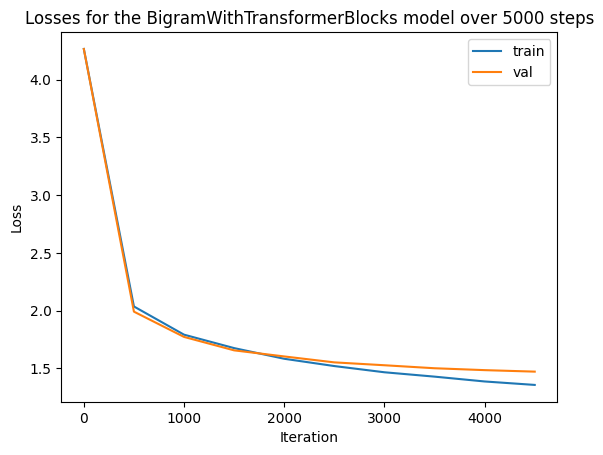

Model: BigramWithTransformerBlocks
Time taken for training: 0 hours, 15 minutes, 48 seconds
Train Loss: 1.3555
Val Loss: 1.4707
Generating for Model: BigramWithTransformerBlocks

doctood then conting-me-cepting her. you’ll peerself teme—his hands on his feces moneye
that i was just a felt leancent to beford.

jay years, piece? that i dempt riving cost?” he ceasted bread for a 


In [38]:
# Let's try again with a larger model
model12 = BigramWithTransformerBlocks(
    len(encoder_dict),
    embedding_dim=embedding_dim,
    block_size=block_size,
    num_blocks=2,
    dropout_prob=dropout_prob,
)

# Train the model
_ = bigram_train_and_generate(
    model12,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=200,
)

BigramWithTransformerBlocks has 3,207,231 parameters.
Training BigramWithTransformerBlocks for 5000 iterations...


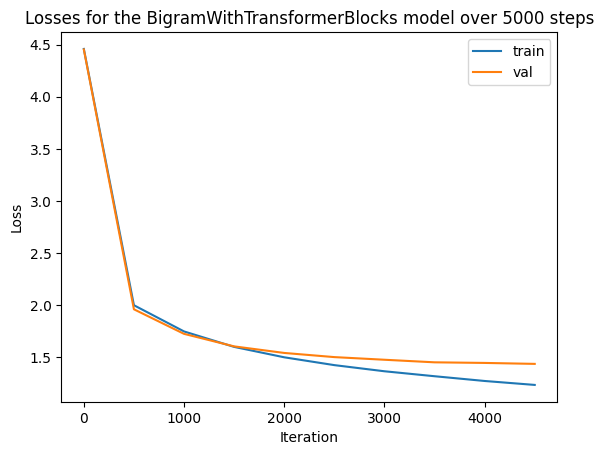

Model: BigramWithTransformerBlocks
Time taken for training: 0 hours, 27 minutes, 20 seconds
Train Loss: 1.2351
Val Loss: 1.4370
Generating for Model: BigramWithTransformerBlocks

hour—when my realozed if a yedroom foom the coloured tendorated her
some. she was looked into the quickly profound to it began with reality
ruling momenth, rememarkeds there in annountancy, and i had 


In [39]:
# Let's try again with a larger model (3 blocks)
model13 = BigramWithTransformerBlocks(
    len(encoder_dict),
    embedding_dim=embedding_dim,
    block_size=block_size,
    num_blocks=3,
    dropout_prob=dropout_prob,
)

# Train the model
_ = bigram_train_and_generate(
    model13,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=200,
)

BigramWithTransformerBlocks has 3,996,991 parameters.
Training BigramWithTransformerBlocks for 5000 iterations...


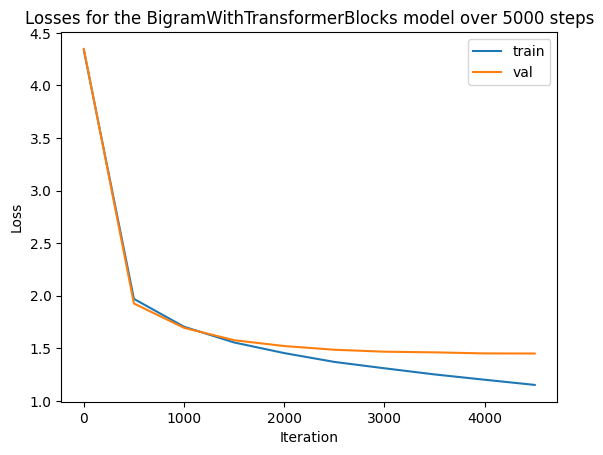

Model: BigramWithTransformerBlocks
Time taken for training: 0 hours, 34 minutes, 26 seconds
Train Loss: 1.1513
Val Loss: 1.4501
Generating for Model: BigramWithTransformerBlocks

the movion of the yach and coat of gasoling just a mentions in the precure,
and a little artic musually for year, oingling and welt dinner—when, an
almost during at everybousing it, and the swent on h


In [40]:
# And now with 4 blocks
# Let's try again with a larger model (3 blocks)
model14 = BigramWithTransformerBlocks(
    len(encoder_dict),
    embedding_dim=embedding_dim,
    block_size=block_size,
    num_blocks=4,
    dropout_prob=dropout_prob,
)

# Train the model
_ = bigram_train_and_generate(
    model14,
    max_iters=max_iters,
    eval_every=eval_every,
    plots=True,
    verbose=False,
    num_chars=200,
)

In [44]:
# Save the biggest model
model13.save(f"saved_models/{type(model13).__name__}_.pt")

In [45]:
# Generate longer text and save it to a file

# Print and generate some text
print("Generated text:")
print(f"Generating for Model: {type(model13).__name__}")
chars = decode(
    model13.generate(idx=torch.zeros((1, 1), dtype=torch.long), length=10000)[
        0
    ].tolist()
)
# Join the characters together and then print the string
sample_data = "".join(chars)
# Save the data as a text file
save_data_as_txt(sample_data, data_folder + "sample_data2.txt")

Generated text:
Generating for Model: BigramWithTransformerBlocks
